RNN


/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
31/31 [==============================] - 11s 95ms/step - loss: 0.4020
Epoch 2/50
31/31 [==============================] - 3s 93ms/step - loss: 0.2095
Epoch 3/50
31/31 [==============================] - 3s 88ms/step - loss: 0.1390
Epoch 4/50
31/31 [==============================] - 3s 104ms/step - loss: 0.1010
Epoch 5/50
31/31 [==============================] - 1s 40ms/step - loss: 0.0804
Epoch 6/50
31/31 [==============================] - 1s 40ms/step - loss: 0.0626
Epoch 7/50
31/31 [==============================] - 1s 40ms/step - loss: 0.0489
Epoch 8/50
31/31 [==============================] - 1s 39ms/step - loss: 0.0395
Epoch 9/50
31/31 [==============================] - 1s 39ms/step - loss: 0.0330
Epoch 10/50
31/31 [==============================] - 1s 39ms/step - loss: 0.0287
Epoch 11/50
31/31 [==============================] - 1s 39ms/step - loss: 0.0230
Epoch 12/50
31/31 [==============================] - 1s 48ms/step - loss: 0.0218
Epoch 13/50
31/31 [================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


RNN Model saved successfully in .h5 format.
8/8 [==============================] - 0s 12ms/step
Evaluation metrics for RELIANCE.NS:
MSE: 25807.54571676175
MAE: 135.59363743516266
R2 Score: 0.46498230806859053

Evaluation metrics for INFY.NS:
MSE: 1959.6739000516236
MAE: 33.180920710329154
R2 Score: 0.8711793424419636

Evaluation metrics for LT.NS:
MSE: 113552.369838728
MAE: 296.9467763431736
R2 Score: 0.49500267810578746

Evaluation metrics for ADANIENT.NS:
MSE: 28948.17805712719
MAE: 125.34435034579919
R2 Score: 0.8338102712764229



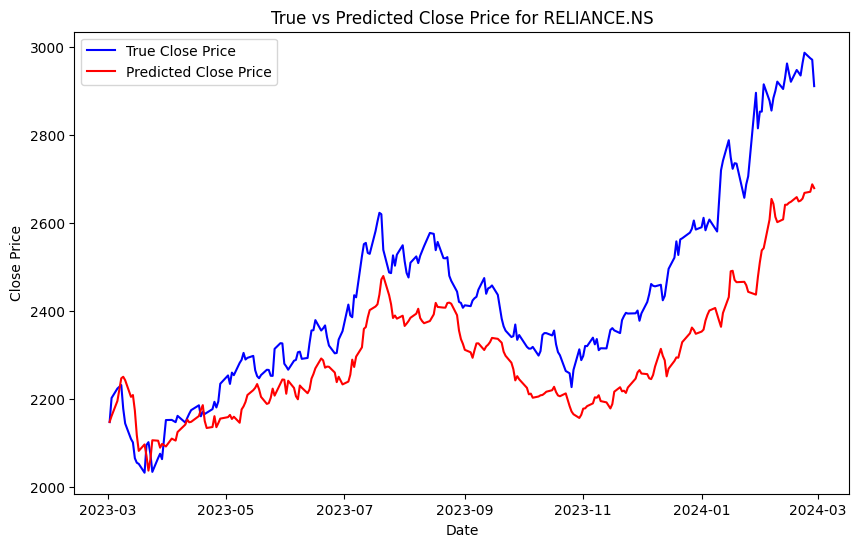

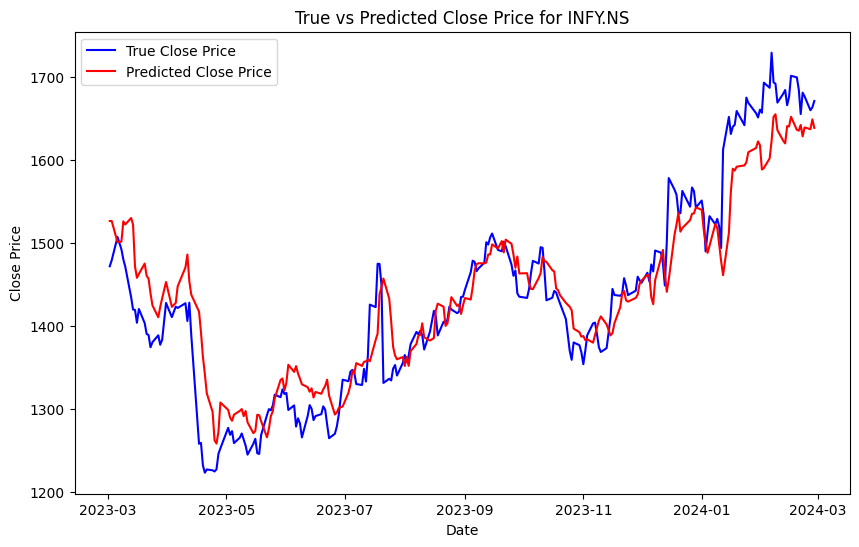

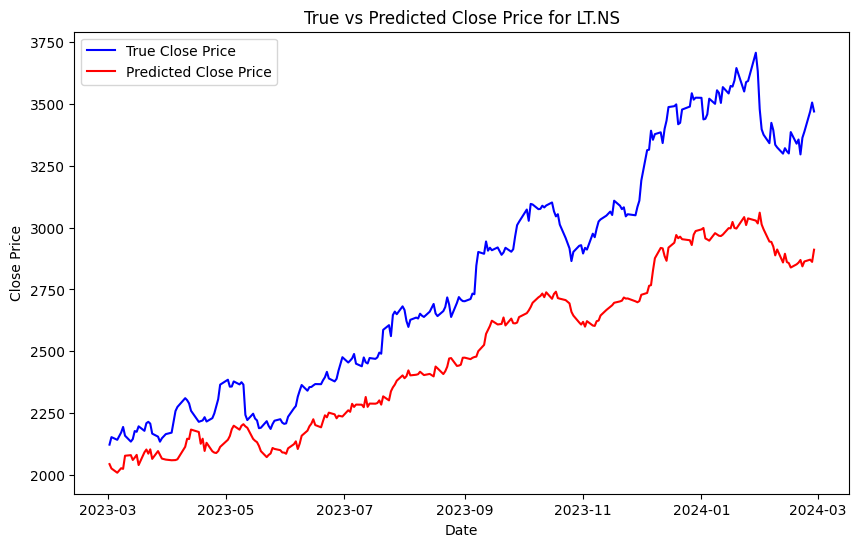

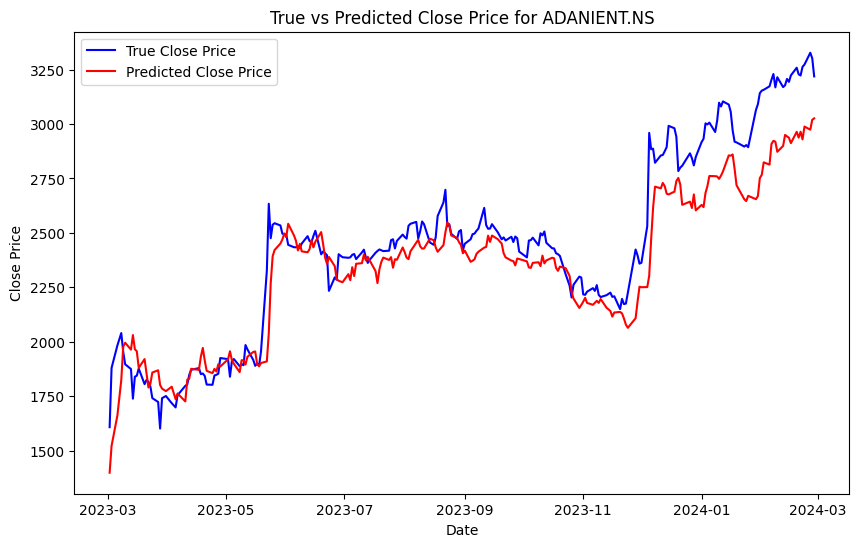

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
import matplotlib.pyplot as plt

# Function to download and preprocess the stock data
def download_and_preprocess_data(tickers, start_date, end_date):
    dfs = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start_date, end=end_date)
        dfs[ticker] = df['Close']
    combined_df = pd.concat(dfs, axis=1)
    return combined_df, dfs

# Function to train and save the RNN model in .h5 format
def train_and_save_rnn_model(X_train, y_train, tickers, epochs=50, filename='rnn_model.h5'):
    np.random.seed(42)  # Set random seed for reproducibility

    model = Sequential([
        SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        SimpleRNN(units=50, return_sequences=True),
        Dropout(0.2),
        SimpleRNN(units=50),
        Dropout(0.2),
        Dense(units=len(tickers))
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)

    # Save the trained model in .h5 format
    model.save(filename)
    print("RNN Model saved successfully in .h5 format.")

# Function to load the saved model from .h5 file
def load_model_from_h5(filename='rnn_model.h5'):
    model = load_model(filename)
    return model

# Function to calculate evaluation metrics
def calculate_evaluation_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Define the stock data parameters
tickers = ['RELIANCE.NS', 'INFY.NS', 'LT.NS', 'ADANIENT.NS']
start_date = '2019-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

# Download and preprocess the data
combined_df, dfs = download_and_preprocess_data(tickers, start_date, end_date)
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(combined_df)
time_step = 60  # Number of time steps
X = []
y = []
for i in range(len(scaled_data) - time_step):
    X.append(scaled_data[i:i + time_step])
    y.append(scaled_data[i + time_step])
X = np.array(X)
y = np.array(y)

# Split the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train and save the RNN model
train_and_save_rnn_model(X_train, y_train, tickers, epochs=50, filename='rnn_model.h5')

# Load the saved RNN model
loaded_model = load_model_from_h5(filename='rnn_model.h5')

# Evaluate the model on the test set
predictions = loaded_model.predict(X_test)
predictions_original_scale = scaler.inverse_transform(predictions)
y_test_original_scale = scaler.inverse_transform(y_test)

# Calculate evaluation metrics for each ticker separately
evaluation_results = {}
for i, ticker in enumerate(tickers):
    mse, mae, r2 = calculate_evaluation_metrics(y_test_original_scale[:, i], predictions_original_scale[:, i])
    evaluation_results[ticker] = {'MSE': mse, 'MAE': mae, 'R2 Score': r2}

# Print evaluation metrics for each ticker separately
for ticker, results in evaluation_results.items():
    print(f"Evaluation metrics for {ticker}:")
    print(f"MSE: {results['MSE']}")
    print(f"MAE: {results['MAE']}")
    print(f"R2 Score: {results['R2 Score']}")
    print()

# Function to plot the results
def plot_results(date_list, true_values, predicted_values, ticker):
    plt.figure(figsize=(10, 6))
    plt.plot(date_list, true_values, label='True Close Price', color='blue')
    plt.plot(date_list, predicted_values, label='Predicted Close Price', color='red')
    plt.title(f'True vs Predicted Close Price for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

# Plot the results for each ticker
for i, ticker in enumerate(tickers):
    # Adjust to get the correct dates for plotting
    plot_length = len(predictions_original_scale)
    date_list = combined_df.index[-plot_length:]
    true_values = y_test_original_scale[:, i]
    predicted_values = predictions_original_scale[:, i]
    plot_results(date_list, true_values, predicted_values, ticker)


LSTM

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
31/31 [==============================] - 15s 162ms/step - loss: 0.0356
Epoch 2/50
31/31 [==============================] - 3s 88ms/step - loss: 0.0098
Epoch 3/50
31/31 [==============================] - 3s 100ms/step - loss: 0.0086
Epoch 4/50
31/31 [==============================] - 5s 157ms/step - loss: 0.0068
Epoch 5/50
31/31 [==============================] - 6s 194ms/step - loss: 0.0067
Epoch 6/50
31/31 [==============================] - 5s 143ms/step - loss: 0.0062
Epoch 7/50
31/31 [==============================] - 3s 96ms/step - loss: 0.0055
Epoch 8/50
31/31 [==============================] - 3s 82ms/step - loss: 0.0052
Epoch 9/50
31/31 [==============================] - 2s 80ms/step - loss: 0.0052
Epoch 10/50
31/31 [==============================] - 2s 80ms/step - loss: 0.0049
Epoch 11/50
31/31 [==============================] - 4s 116ms/step - loss: 0.0045
Epoch 12/50
31/31 [==============================] - 2s 80ms/step - loss: 0.0043
Epoch 13/50
31/31 [===========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


LSTM Model saved successfully in .h5 format.
8/8 [==============================] - 1s 26ms/step
Evaluation metrics for RELIANCE.NS:
MSE: 46904.62260850018
MAE: 193.6751558897925
R2 Score: 0.02761761213834657

Evaluation metrics for INFY.NS:
MSE: 9024.026246839861
MAE: 73.46780345478996
R2 Score: 0.40679875620721007

Evaluation metrics for LT.NS:
MSE: 26332.141644343472
MAE: 143.1731817526895
R2 Score: 0.8828940247656792

Evaluation metrics for ADANIENT.NS:
MSE: 2230395.7061900236
MAE: 1289.6476708083856
R2 Score: -11.804566029214763



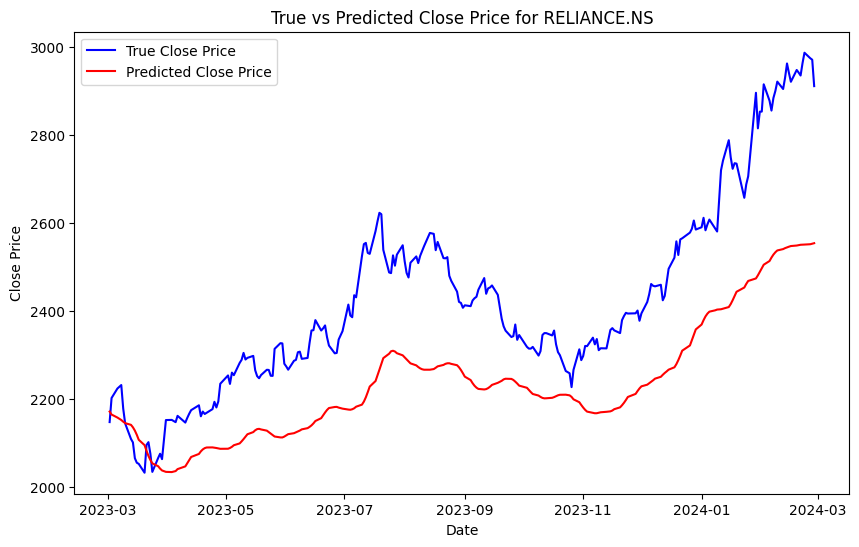

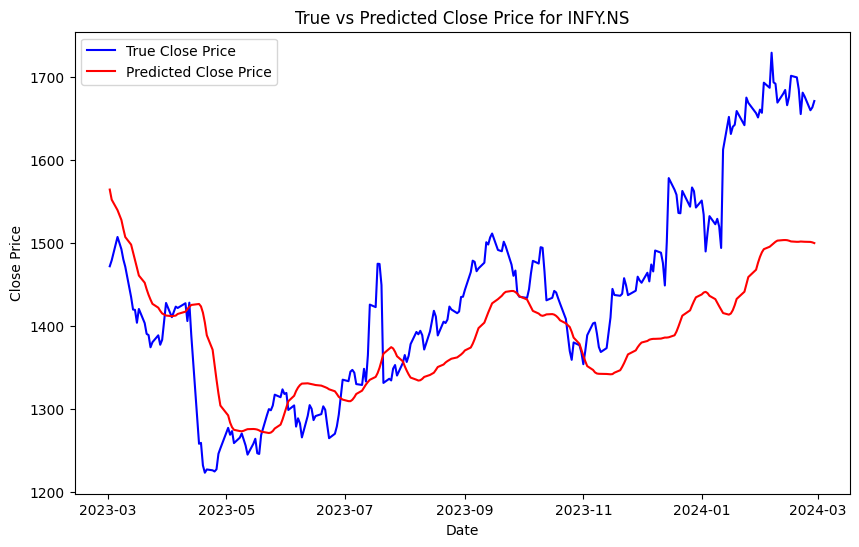

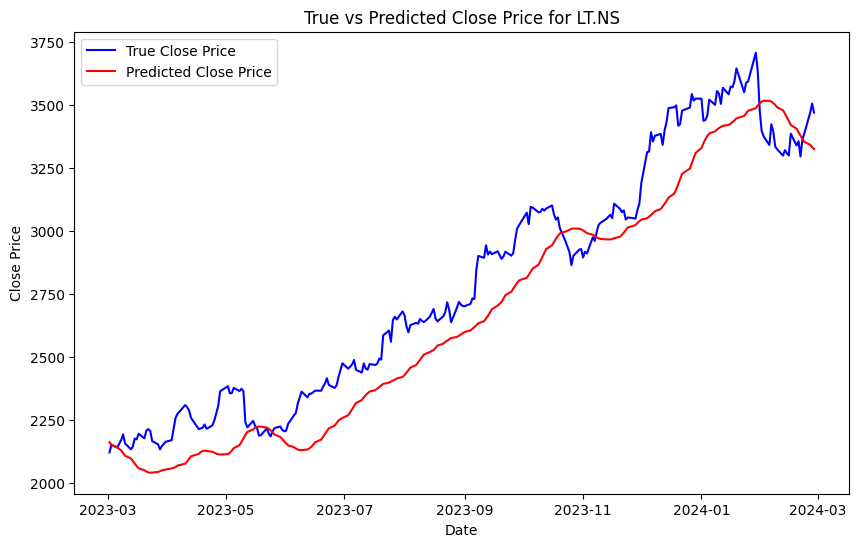

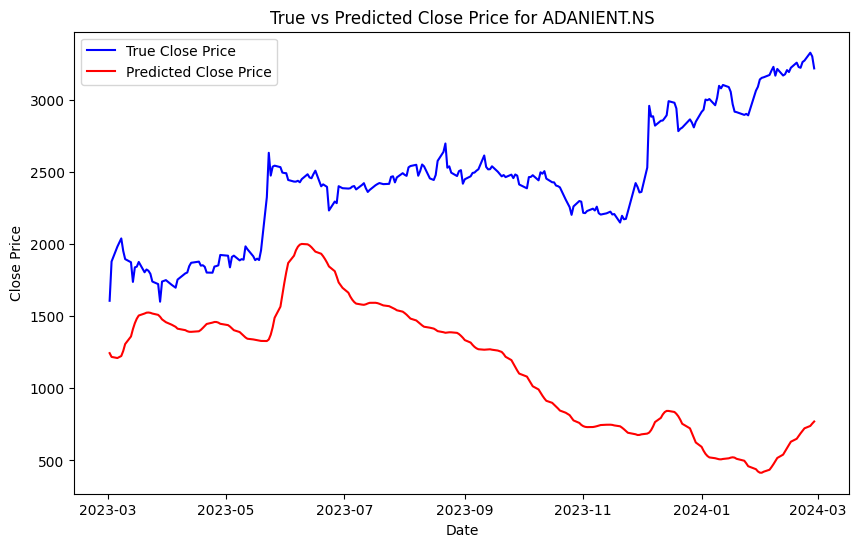

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
import matplotlib.pyplot as plt

# Function to download and preprocess the stock data
def download_and_preprocess_data(tickers, start_date, end_date):
    dfs = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start_date, end=end_date)
        dfs[ticker] = df
    combined_df = pd.DataFrame()
    for ticker, df in dfs.items():
        combined_df[ticker] = df['Close']
    return combined_df, dfs

# Function to train and save the LSTM model in .h5 format
def train_and_save_lstm_model(X_train, y_train, tickers, epochs=50, filename='lstm_model.h5'):
    np.random.seed(42)  # Set random seed for reproducibility

    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(units=50, return_sequences=True),
        Dropout(0.2),
        LSTM(units=50),
        Dropout(0.2),
        Dense(units=len(tickers))  # Adjust the units to the number of tickers
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)

    # Save the trained model in .h5 format
    model.save(filename)
    print("LSTM Model saved successfully in .h5 format.")

# Function to load the saved model from .h5 file
def load_model_from_h5(filename='lstm_model.h5'):
    model = load_model(filename)
    return model

# Function to calculate evaluation metrics
def calculate_evaluation_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Define the stock data parameters
tickers = ['RELIANCE.NS', 'INFY.NS', 'LT.NS', 'ADANIENT.NS']
start_date = '2019-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')  # Format the current date

# Download and preprocess the data
combined_df, dfs = download_and_preprocess_data(tickers, start_date, end_date)
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(combined_df)
time_step = 60  # Number of time steps
X = []
y = []
for i in range(len(scaled_data) - time_step):
    X.append(scaled_data[i:i + time_step])
    y.append(scaled_data[i + time_step])
X = np.array(X)
y = np.array(y)

# Split the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train and save the LSTM model
train_and_save_lstm_model(X_train, y_train, tickers, epochs=50, filename='lstm_model.h5')

# Load the saved LSTM model
loaded_model = load_model_from_h5(filename='lstm_model.h5')

# Evaluate the model on the test set
predictions = loaded_model.predict(X_test)
predictions_original_scale = scaler.inverse_transform(predictions)
y_test_original_scale = scaler.inverse_transform(y_test)

# Calculate evaluation metrics for each ticker separately
evaluation_results = {}
for i, ticker in enumerate(tickers):
    mse, mae, r2 = calculate_evaluation_metrics(y_test_original_scale[:, i], predictions_original_scale[:, i])
    evaluation_results[ticker] = {'MSE': mse, 'MAE': mae, 'R2 Score': r2}

# Print evaluation metrics for each ticker separately
for ticker, results in evaluation_results.items():
    print(f"Evaluation metrics for {ticker}:")
    print(f"MSE: {results['MSE']}")
    print(f"MAE: {results['MAE']}")
    print(f"R2 Score: {results['R2 Score']}")
    print()

# Function to plot the results
def plot_results(date_list, true_values, predicted_values, ticker):
    plt.figure(figsize=(10, 6))
    plt.plot(date_list, true_values, label='True Close Price', color='blue')
    plt.plot(date_list, predicted_values, label='Predicted Close Price', color='red')
    plt.title(f'True vs Predicted Close Price for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

# Plot the results for each ticker
for i, ticker in enumerate(tickers):
    date_list = dfs[ticker].index.tolist()[-len(y_test_original_scale):]
    true_values = y_test_original_scale[:, i]
    predicted_values = predictions_original_scale[:, i]
    plot_results(date_list, true_values, predicted_values, ticker)


GRU

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Epoch 1/50
31/31 [==============================] - 8s 84ms/step - loss: 0.0424
Epoch 2/50
31/31 [==============================] - 4s 117ms/step - loss: 0.0096
Epoch 3/50
31/31 [==============================] - 3s 84ms/step - loss: 0.0078
Epoch 4/50
31/31 [==============================] - 3s 85ms/step - loss: 0.0070
Epoch 5/50
31/31 [==============================] - 3s 85ms/step - loss: 0.0063
Epoch 6/50
31/31 [==============================] - 3s 112ms/step - loss: 0.0057
Epoch 7/50
31/31 [==============================] - 3s 90ms/step - loss: 0.0056
Epoch 8/50
31/31 [==============================] - 3s 84ms/step - loss: 0.0051
Epoch 9/50
31/31 [==============================] - 3s 85ms/step - loss: 0.0048
Epoch 10/50
31/31 [==============================] - 3s 86ms/step - loss: 0.0043
Epoch 11/50
31/31 [==============================] - 4s 115ms/step - loss: 0.0044
Epoch 12/50
31/31 [==============================] - 3s 83ms/step - loss: 0.0042
Epoch 13/50
31/31 [===============

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 2s 33ms/step
Evaluation metrics for RELIANCE.NS:
MSE: 25687.515669545006
MAE: 144.35618166063654
R2 Score: 0.46747065777565355
Evaluation metrics for INFY.NS:
MSE: 2470.4237698935835
MAE: 38.990478515625
R2 Score: 0.8376048104348834
Evaluation metrics for LT.NS:
MSE: 32763.75839028518
MAE: 158.29007408267157
R2 Score: 0.8542909296760443
Evaluation metrics for ADANIENT.NS:
MSE: 47615.65884172171
MAE: 177.33742835873463
R2 Score: 0.726641400011983


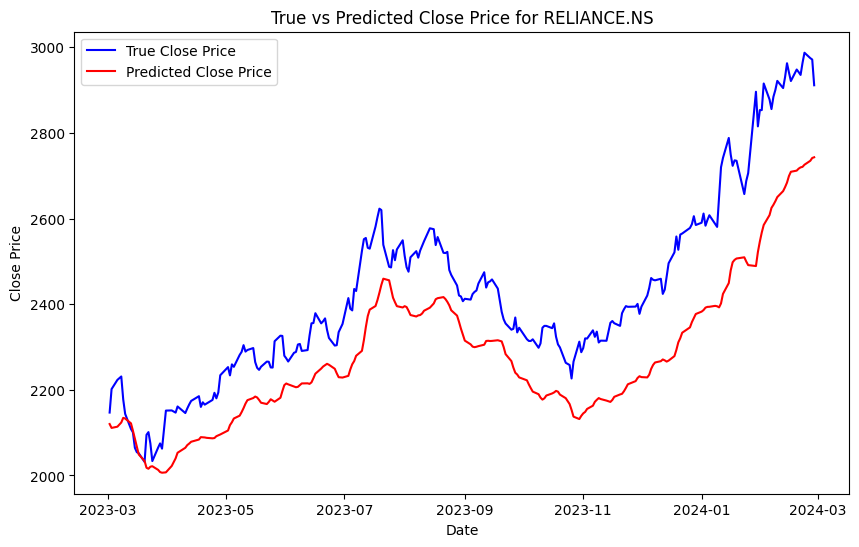

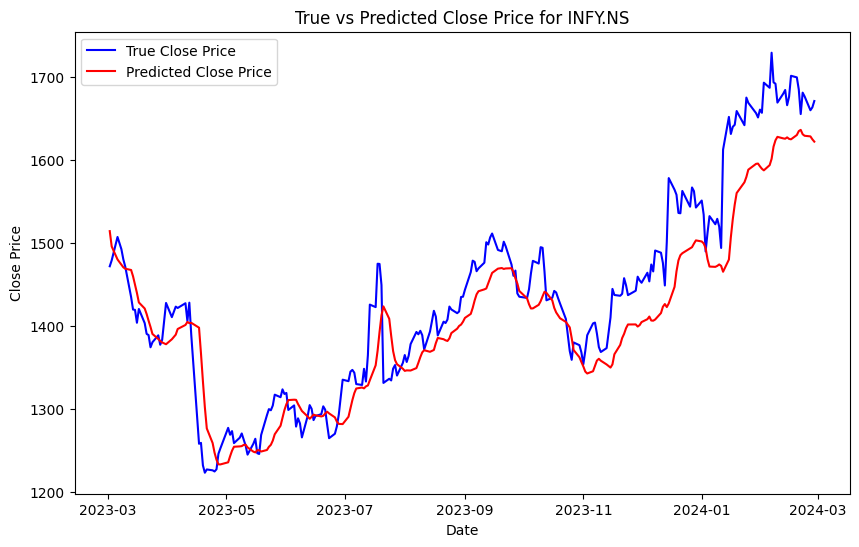

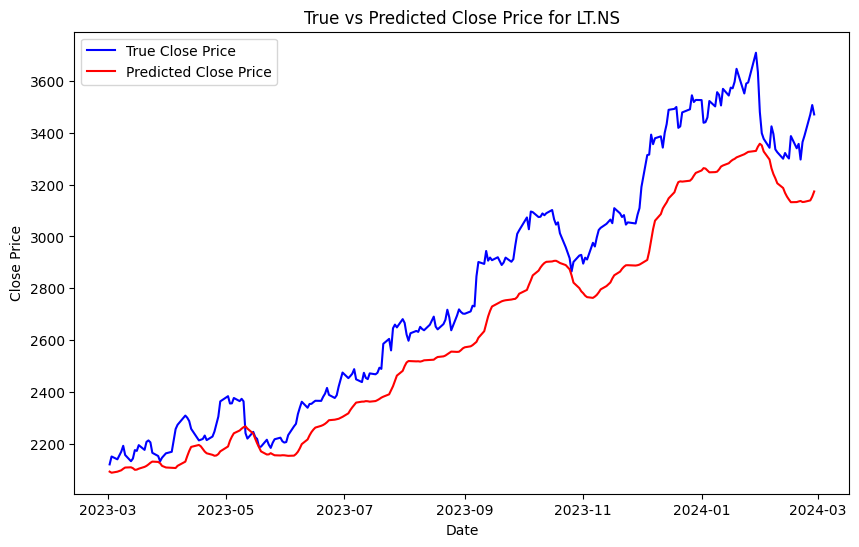

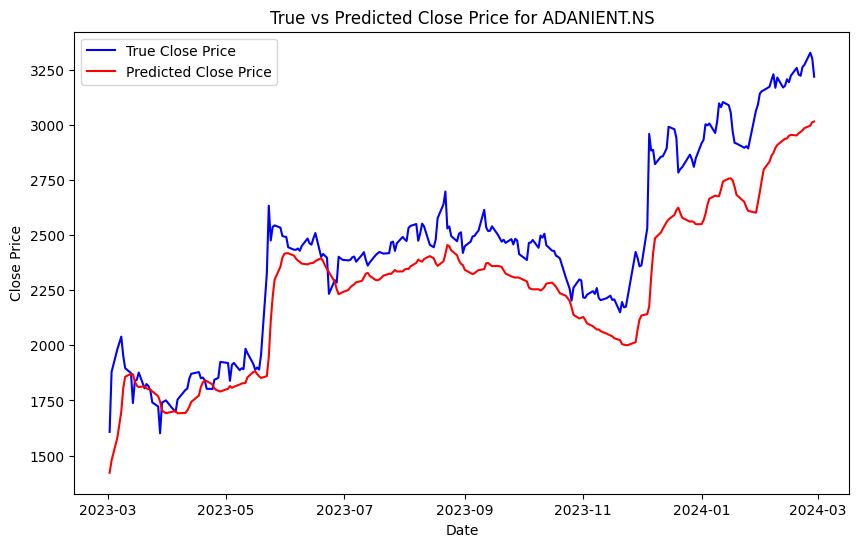

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import yfinance as yf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GRU, Dropout, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime
import matplotlib.pyplot as plt

# Function to download and preprocess the stock data
def download_and_preprocess_data(tickers, start_date, end_date):
    dfs = {}
    for ticker in tickers:
        df = yf.download(ticker, start=start_date, end=end_date)
        dfs[ticker] = df
    combined_df = pd.DataFrame()
    for ticker, df in dfs.items():
        combined_df[ticker] = df['Close']
    return combined_df, dfs

# Function to train and save the GRU model in .h5 format
def train_and_save_gru_model(X_train, y_train, tickers, epochs=50, filename='gru_model.h5'):
    np.random.seed(42)  # Set random seed for reproducibility

    model = Sequential([
        GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        GRU(units=50, return_sequences=True),
        Dropout(0.2),
        GRU(units=50),
        Dropout(0.2),
        Dense(units=len(tickers))  # Adjust the units to the number of tickers
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)

    # Save the trained model in .h5 format
    model.save(filename)
    print("GRU Model saved successfully in .h5 format.")

# Function to load the saved model from .h5 file
def load_model_from_h5(filename='gru_model.h5'):
    model = load_model(filename)
    return model

# Function to calculate evaluation metrics
def calculate_evaluation_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, r2

# Define the stock data parameters
tickers = ['RELIANCE.NS', 'INFY.NS', 'LT.NS', 'ADANIENT.NS']
start_date = '2019-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')  # Format the current date

# Download and preprocess the data
combined_df, dfs = download_and_preprocess_data(tickers, start_date, end_date)
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(combined_df)
time_step = 60  # Number of time steps
X = []
y = []
for i in range(len(scaled_data) - time_step):
    X.append(scaled_data[i:i + time_step])
    y.append(scaled_data[i + time_step])
X = np.array(X)
y = np.array(y)

# Split the data into train and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Train and save the GRU model
train_and_save_gru_model(X_train, y_train, tickers, epochs=50, filename='gru_model.h5')

# Load the saved GRU model
loaded_model = load_model_from_h5(filename='gru_model.h5')

# Evaluate the model on the test set
predictions = loaded_model.predict(X_test)
predictions_original_scale = scaler.inverse_transform(predictions)
y_test_original_scale = scaler.inverse_transform(y_test)

# Calculate evaluation metrics for each ticker separately
evaluation_results = {}
for i, ticker in enumerate(tickers):
    mse, mae, r2 = calculate_evaluation_metrics(y_test_original_scale[:, i], predictions_original_scale[:, i])
    evaluation_results[ticker] = {'MSE': mse, 'MAE': mae, 'R2 Score': r2}

# Print evaluation metrics for each ticker separately
for ticker, results in evaluation_results.items():
    print(f"Evaluation metrics for {ticker}:")
    print(f"MSE: {results['MSE']}")
    print(f"MAE: {results['MAE']}")
    print(f"R2 Score: {results['R2 Score']}")

# Function to plot the results
def plot_results(date_list, true_values, predicted_values, ticker):
    plt.figure(figsize=(10, 6))
    plt.plot(date_list, true_values, label='True Close Price', color='blue')
    plt.plot(date_list, predicted_values, label='Predicted Close Price', color='red')
    plt.title(f'True vs Predicted Close Price for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

# Plot the results for each ticker
for i, ticker in enumerate(tickers):
    date_list = dfs[ticker].index.tolist()[-len(y_test_original_scale):]
    true_values = y_test_original_scale[:, i]
    predicted_values = predictions_original_scale[:, i]
    plot_results(date_list, true_values, predicted_values, ticker)
